# Translate and Interpret Samples

This notebook trains a vanilla seq2seq model for German to English Translation on Multi30K dataset. It makes translate a sample sentence and interprets the translation using integrated gradients method.

The model was trained using an open source sentiment analysis tutorials described in [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)


# Part 1 - Training Model

In [1]:
import fairseq
import math
import numpy as np
import random
import spacy

import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable



In [2]:
import os
os.environ['HTTP_PROXY'] = "http://fwdproxy:8080"
os.environ['HTTPS_PROXY'] = "https://fwdproxy:8080"
os.environ['http_proxy'] = "fwdproxy:8080"
os.environ['https_proxy'] = "fwdproxy:8080"

In [3]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")



Load Dataset

In [4]:
SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spaCy has model for a handful of languages ("de" for German and "en" for English).

In [5]:
# for tokenizing the english sentences
spacy_en = spacy.load('en')
# for tokenizing the german sentences
spacy_de = spacy.load('de')

In [6]:
def tokenize_de(text):
    # tokenizes the german text into a list of strings(tokens)
    return [tok.text for tok in spacy_de.tokenizer(text)]


def tokenize_en(text):
    # tokenizes the english text into a list of strings(tokens)
    return [tok.text for tok in spacy_en.tokenizer(text)]

TorchText's Fields handle how data should be processed. 

In [7]:
SRC = torchtext.data.Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = torchtext.data.Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

For this task, we are using the Multi30K dataset, which is built in dataset in torchtext.

In [8]:
train_data, valid_data, test_data = torchtext.datasets.Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [9]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

Create data iterator

In [10]:
# define batch size
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device
)

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
     
    def forward(self, src):
        
        #src = [src sent len, batch size]
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        #outputs = [src sent len, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        return hidden, cell

In [12]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, output_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        #input = [batch size]
        input = input.unsqueeze(0)
        
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]

        predicted = self.linear(output.squeeze(0))
        #predicted = [batch size, output dim]
        
        return predicted, hidden, cell
    
    

In [13]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio=0):
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0, :]
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output 
            use_teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if use_teacher_force else top1)
            
        return outputs

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 256   # encoder embedding size
DEC_EMB_DIM = 256   # decoder embedding size (can be different from encoder embedding size)
HID_DIM = 512       # hidden dimension (must be same for encoder & decoder)
N_LAYERS = 2        # number of rnn layers (must be same for encoder & decoder)
ENC_DROPOUT = 0.5   # encoder dropout
DEC_DROPOUT = 0.5   # decoder dropout (can be different from encoder droput)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec)

In [15]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (linear): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [16]:
optimizer = optim.Adam(model.parameters())

The loss function calculates the average loss per token, however by passing the index of the <pad> token as the ignore_index argument we ignore the loss whenever the target token is a padding token.

In [17]:
pad_idx = TRG.vocab.stoi['<pad>']

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            output = model(src, trg, 0)
            
            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

            epoch_loss += loss.item()
    
    return epoch_loss/len(iterator), output


In [21]:
# N_EPOCHS = 10           # number of epochs
# CLIP = 10               # gradient clip value
# SAVE_DIR = 'models'     # directory name to save the models.
# MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'seq2seq_model.pt')

# best_validation_loss = float('inf')

# if not os.path.isdir(f'{SAVE_DIR}'):
#     os.makedirs(f'{SAVE_DIR}')

# for epoch in range(N_EPOCHS):
#     print (os.path.join('seq2seq_model_{}.pt').format(str(epoch)))
#     train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion)

#     if valid_loss < best_validation_loss:
#         best_validation_loss = valid_loss
#         torch.save(model.state_dict(), os.path.join('seq2seq_model_{}.pt').format(str(epoch)))
#         print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')

# Part 2 - Interpreting Translation

Loads the pretrained model.

In [22]:
from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


In [23]:
pretrained_model = Seq2Seq(enc, dec)

In [24]:
pretrained_model.load_state_dict(torch.load('/home/irisz/local/notebooks/migrated_notebooks/seq2seq_model_6.pt'))

<All keys matched successfully>

Forward method that allows you to extract a output tensor at a specific index.

In [25]:
def ig_forward(src, trg, idx):
    # Make sure the dimentaionality of the output is [batch_size, vocab_size]
    # The batch_size is 1 as we are running on 1 sample
    assert (model.forward(src, trg)[idx][0].unsqueeze(0).shape == (1, len(TRG.vocab)))
    return model.forward(src, trg)[idx][0].unsqueeze(0)

In order to explain text features, we introduce interpretable embedding layers which allows access word embeddings and generate meaningful attributions for each embedding dimension.

configure_interpretable_embedding_layer function separates embedding layer from the model and precomputes word embeddings in advance. The embedding layer of our model is then being replaced by an Interpretable Embedding Layer which wraps original embedding layer and takes word embedding vectors as inputs of the forward function. This allows to generate baselines for word embeddings and compute attributions for each embedding dimension.

Note: After finishing interpretation it is important to call remove_interpretable_embedding_layer which removes the Interpretable Embedding Layer that we added for interpretation purposes and sets the original embedding layer back in the model.

In [26]:
interpretable_embedding = configure_interpretable_embedding_layer(pretrained_model, 'encoder.embedding')

/data/users/irisz/captum/captum/attr/_models/base.py:133: UserWarning: In order to make embedding layers more interpretable they will
        be replaced with an interpretable embedding layer which wraps the
        original embedding layer and takes word embedding vectors as inputs of
        the forward function. This allows to generate baselines for word
        embeddings and compute attributions for each embedding dimension.
        The original embedding layer must be set
        back by calling `remove_interpretable_embedding_layer` function
        after model interpretation is finished.
  after model interpretation is finished."""


In [27]:
pretrained_model

Seq2Seq(
  (encoder): Encoder(
    (embedding): InterpretableEmbeddingBase(
      7855, 256
      (embedding): Embedding(7855, 256)
    )
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (linear): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
ig = IntegratedGradients(ig_forward)

In [92]:
def interpret_sentence(model, src, trg):
    
    # get a list of src_tokens from the src sentence
    src_tokens = tokenize_de(src)
    src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
    src_indices = [[SRC.vocab.stoi[t]] for t in src_tokens]
    
    # get a list of trg_tokens from the trg sentence
    trg_tokens = tokenize_en(trg)
    trg_tokens = [TRG.init_token] + trg_tokens + [TRG.eos_token]
    trg_indices = [[TRG.vocab.stoi[t]] for t in trg_tokens]
    
    model.eval()
    model.zero_grad()
    
    # pre-computing word embeddings
    src_indices = torch.LongTensor(src_indices)
    src_embedding = interpretable_embedding.indices_to_embeddings(src_indices)
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    trg_indices = torch.LongTensor(trg_indices)
    outputs = model(src_embedding, trg_indices, 0).squeeze(0)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    for idx, output in enumerate(outputs):
        max_idx = torch.argmax(output.squeeze(0))
        output_token = TRG.vocab.itos[max_idx]
        output_tokens.append(output_token)
        
        attribution_ig, delta =  ig.attribute(src_embedding, additional_forward_args=(trg_indices, idx), target=max_idx, n_steps=10)
        attribution_igs.append(attribution_ig)
    
    return attribution_igs, output_tokens
    

Visualize attribution by creating a matrix of probablity of size \[len(output_tokens), len(src_tokens)\]

In [182]:
import matplotlib
import matplotlib.pyplot as plt
import numpy

def plot_attributions(attribution_igs, src, output_tokens):
    # This is an example of how we can visualize attributions.
    # We plot an attribution-based alignments between every output token and every input token.
    
    # get a list of src_tokens from the src sentence
    src_tokens = tokenize_de(src)
    src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
    
    # For each output token, we aggregate and normalize attribution of each input token.
    normalized_attribution_igs = [] #size [len(output_tokens), len(src_tokens)]
    end_idx = len(output_tokens) - 1
    for idx, attribution_ig in enumerate(attribution_igs):
        # Disregard the token <eos> token at the end of the output_tokens.
        if output_tokens[idx] == SRC.eos_token:
            end_idx = idx
            break
            
        attribution_ig = attribution_ig.sum(dim=2).squeeze(0)
        attribution_ig /= torch.norm(attribution_ig)
        attribution_ig = attribution_ig.detach().squeeze(1).numpy()
        normalized_attribution_igs.append(attribution_ig)
    
    normalized_attribution_igs = numpy.array(normalized_attribution_igs)
    
    plot_heatmap(normalized_attribution_igs[:].transpose(), output_tokens, src_tokens)


The heatmap was created based on documentation of creating annotated heatmaps on matplotlib. For more info, read [here](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html.

In [186]:
def plot_heatmap(data, x_labels, y_labels):
    
    ax = plt.gca()
    
    # Plot the heatmap
    im = ax.imshow(data, cmap='RdBu', interpolation='nearest', aspect='auto')
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("attributions", rotation=-90, va="bottom")
    
    # how all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Output Sequence')
    ax.set_ylabel('Input Sequence')
    
    # Turn spines off and create white grid
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    # Set alignment to center
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update()
    
    # Get the formatter in case a string is supplied
    valfmt = "{x:.1f}"
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    
    # Loop over the data and assign the probablity for each output-input token alignment pair.
    # Change the color of probability depending on the value.
    textcolors =["black", "white"]
    threshold = im.norm(data.max())/2.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] == "nan":
                continue
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    

Translate sample sentences and interpret them

In [180]:
attribution_igs, output_tokens = interpret_sentence(
    pretrained_model, 
    'Ein mann im blauen Hemd.', 
    'a man in blue shirt.'
)

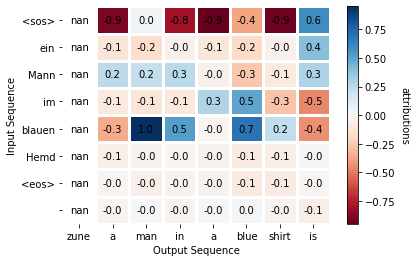

In [181]:
plot_attributions(attribution_igs, 'ein Mann im blauen Hemd', output_tokens)

In [187]:
remove_interpretable_embedding_layer(pretrained_model, interpretable_embedding)